In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def single_mode_matricization(T, j):
    """
    Matricization of numpy array `T` by partitioning into j-th dimension and the remaining dimensions.
    """
    assert j < T.ndim
    # bring j-th dimension to the front
    T = np.transpose(T, [j] + list(range(j)) + list(range(j + 1, T.ndim)))
    T = np.reshape(T, (T.shape[0], -1)) # size of second dimension is inferred
    return T

In [3]:
def single_mode_product(A, T, j):
    """
    Compute the j-mode product between the matrix `A` and tensor `T`.
    """
    T = np.tensordot(A, T, axes=(1, j))
    # original j-th dimension is now 0-th dimension; move back to j-th place
    T = np.transpose(T, list(range(1, j + 1)) + [0] + list(range(j + 1, T.ndim)))
    return T

In [4]:
def higher_order_svd(T, max_ranks):
    """
    Compute the higher-order singular value decomposition (Tucker format approximation) of `T`.
    """
    assert T.ndim == len(max_ranks)
    Ulist = []
    σlist = []
    for j in range(T.ndim):
        A = single_mode_matricization(T, j)
        U, σ, Vh = np.linalg.svd(A, full_matrices=False)
        χ = U.shape[1]
        if max_ranks[j] > 0:
            # truncate in case max_ranks[j] < χ
            χ = min(χ, max_ranks[j])
        Ulist.append(U[:, :χ])
        σlist.append(σ)
    # form the core tensor
    C = T
    for j in range(C.ndim):
        # apply Uj^\dagger to j-th dimension
        C = single_mode_product(Ulist[j].conj().T, C, j)
    return Ulist, C, σlist

In [5]:
# load computational fluid dynamics (CFD) velocity data from disk
# (array only contains the y-component of the velocity vector)
vcfd = np.load("cfd_velocity.npy")
# dimensions are (x, y, time)
vcfd.shape

(21, 101, 50)

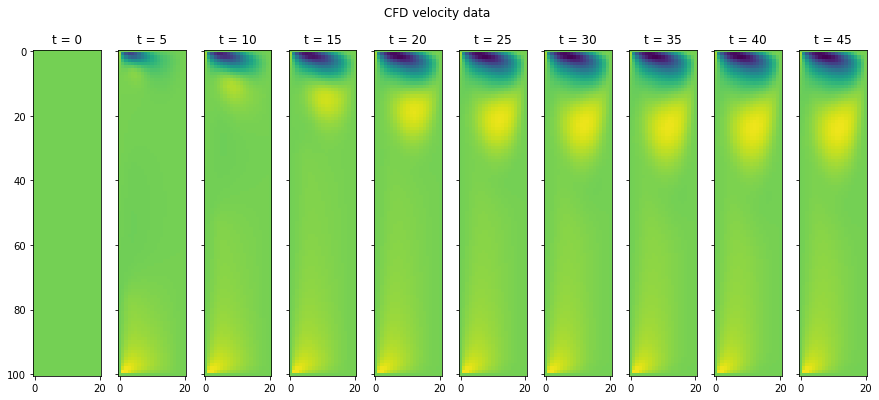

In [6]:
# visualize data
fig, ax = plt.subplots(1, 10, sharey=True, figsize=(15, 6))
plt.suptitle("CFD velocity data")
# use same color range in all subplots
vmin_dat = np.min(vcfd)
vmax_dat = np.max(vcfd)
for j in range(10):
    ax[j].imshow(vcfd[:, :, 5*j].T, vmin=vmin_dat, vmax=vmax_dat)
    ax[j].set_title("t = {}".format(5*j))
plt.show()

In [7]:
# perform HOSVD
max_ranks = [5, 10, 8]
Ulist, C, σlist = higher_order_svd(vcfd, max_ranks)
# must agree with `max_ranks`
print("C.shape:", C.shape)
np.allclose(C.shape, max_ranks)

C.shape: (5, 10, 8)


True

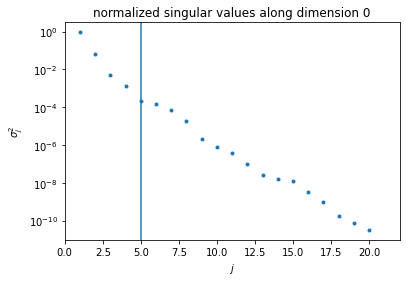

In [8]:
plt.semilogy(range(1, len(σlist[0]) + 1), σlist[0]**2 / np.sum(σlist[0]**2), '.')
plt.axvline(x=max_ranks[0])
plt.ylabel("$\\sigma_j^2$")
plt.xlabel("$j$")
plt.title("normalized singular values along dimension 0");
plt.show()

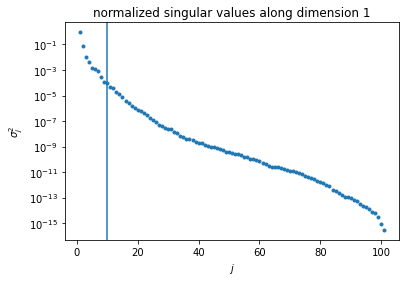

In [9]:
plt.semilogy(range(1, len(σlist[1]) + 1), σlist[1]**2 / np.sum(σlist[1]**2), '.')
plt.axvline(x=max_ranks[1])
plt.ylabel("$\\sigma_j^2$")
plt.xlabel("$j$")
plt.title("normalized singular values along dimension 1");
plt.show()

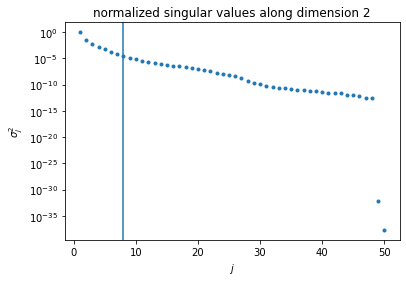

In [10]:
plt.semilogy(range(1, len(σlist[2]) + 1), σlist[2]**2 / np.sum(σlist[2]**2), '.')
plt.axvline(x=max_ranks[2])
plt.ylabel("$\\sigma_j^2$")
plt.xlabel("$j$")
plt.title("normalized singular values along dimension 2");
plt.show()

In [11]:
# The Tucker tensor as "full" tensor should only be constructed for debugging and testing.
# Typically one works with the `U` matrices and the core tensor `C` directly.
def construct_tucker_tensor(Ulist, C):
    """
    Construct the full Tucker tensor based on the `U` matrices and the core tensor `C`. 
    """
    assert C.ndim == len(Ulist)
    T = C
    for j in range(T.ndim):
        # apply Uj to j-th dimension
        T = single_mode_product(Ulist[j], T, j)
    return T

In [12]:
vcfd_tucker = construct_tucker_tensor(Ulist, C)
# should be equal to original dimensions
vcfd_tucker.shape

(21, 101, 50)

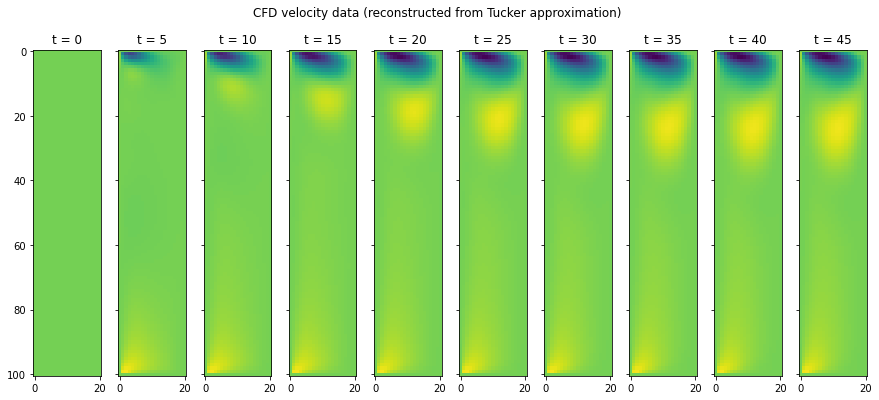

In [13]:
# visualize reconstructed Tucker approximation (should visually match the original data well)
fig, ax = plt.subplots(1, 10, sharey=True, figsize=(15, 6))
plt.suptitle("CFD velocity data (reconstructed from Tucker approximation)")
for j in range(10):
    ax[j].imshow(vcfd_tucker[:, :, 5*j].T, vmin=vmin_dat, vmax=vmax_dat)
    ax[j].set_title("t = {}".format(5*j))
plt.show()

We see that the plotted reconstructed data actually resembles the plot of the original data above.